
## Importing Data

In [ ]:
!pip install hub

In [ ]:
import hub
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import TensorDataset
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import image

from tqdm import tqdm
import glob
import cv2
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

NumExpr defaulting to 2 threads.


In [ ]:
plt.rcParams["figure.figsize"] = (12,6)
region_code_to_label = ['elbow', 'finger', 'forearm', 'hand', 'humerus', 'shoulder', 'wrist']

In [ ]:
if torch.cuda.is_available():
  device=torch.device("cuda:0")
  print("Running GPU")
else :
  device= torch.device("cpu")
  print("Running CPU")

Running GPU


In [ ]:
ds = hub.load("hub://activeloop/mura-train")

Opening dataset in read-only mode as you don't have write permissions.
hub://activeloop/mura-train loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/mura-train


## Converting into pytorch dataloader , ['images']- >image , ['study_type']->label

In [ ]:
preprocess = transforms.Compose([
    transforms.ToPILImage(), # Necessary
    transforms.Resize((224,224)),
    transforms.ToTensor(), # Normalises 
])

In [ ]:
dll=ds.pytorch(batch_size=64,transform = {'images': preprocess, 'study_type': None, 'region': None},num_workers=2 )

## Data Visualisation

In [ ]:
reg0=[]
reg1=[]
reg2=[]
reg3=[]
reg4=[]
reg5=[]
reg6=[]
for i in tqdm(dll):
  for j in range(64):
    if (i['region'][j]==0):
      reg0.append((i['images'][j],i['study_type'][j],i['region'][j]))
    if (i['region'][j]==1):
      reg1.append((i['images'][j],i['study_type'][j],i['region'][j]))
    if (i['region'][j]==2):
      reg2.append((i['images'][j],i['study_type'][j],i['region'][j]))
    if (i['region'][j]==3):
      reg3.append((i['images'][j],i['study_type'][j],i['region'][j]))
    if (i['region'][j]==4):
      reg4.append((i['images'][j],i['study_type'][j],i['region'][j]))
    if (i['region'][j]==5):
      reg5.append((i['images'][j],i['study_type'][j],i['region'][j]))
    if (i['region'][j]==6):
      reg6.append((i['images'][j],i['study_type'][j],i['region'][j]))
   

In [ ]:
i=0
for x in dll:
  print(x['images'][0])
  i+=1

In [ ]:
for x in dll:
  print(x['images'][0],x)
  break

In [ ]:
def plot_loss(train_loss):
  plt.plot(range(len(train_loss)), train_loss, label = "Average Training  Loss " )
  # plt.plot(range(len(val_loss)), val_loss, label = "Average Validation  Loss " )
  plt.xlabel('Epochs ')
  plt.ylabel('Loss')
  plt.title("Training loss and validation loss vs Epochs")
  plt.legend()
  plt.show()

## DenseNet Model

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet169', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
class Net (nn.Module) :
  def __init__ (self, densenet):
    super().__init__()
    # define the layers here
    self.densenet=densenet  # LAST LAYER GIVES 1000 output
    # self.batchnorm1=nn.BatchNorm1d(1000,eps=1e-5)
    self.fc1=nn.Linear(1000, 500)
    # self.batchnorm2=nn.BatchNorm1d(500,eps=1e-5)
    self.fc2=nn.Linear(500,250)
    self.fc3=nn.Linear(250,100)
    # self.drop1 = nn.Dropout(p=0.2)
    self.fc4=nn.Linear(100,50)
    # self.drop2 = nn.Dropout(p=0.2)
    self.fc5=nn.Linear(50,1)
    # self.wt_init(weights)

  def forward(self,x):
    x=self.densenet(x)
    x = F.normalize(x)
    # x=self.batchnorm1(x)
    x=torch.tanh(self.fc1(x))
    # x=self.batchnorm2(x)
    x=torch.tanh(self.fc2(x))
    # x=self.drop1(x)
    x=torch.tanh(self.fc3(x))
    # x=self.drop2(x)
    x=torch.tanh(self.fc4(x))
    x = F.normalize(x)
    x=torch.sigmoid(self.fc5(x))
   
    return x.view(-1)

  def wt_init(self, weights):
    f = 0
    for m in self.modules():
      if(isinstance(m, nn.Linear) and f == 1):
        if(weights == "xavier"):
          nn.init.xavier_uniform_(m.weight, 0)
          nn.init.constant_(m.bias, 0)
        elif(weights == "random"):
          nn.init.normal_(m.weight, mean=0, std=1.0)
          nn.init.constant_(m.bias, 0)
        elif(weights == "he"):
          nn.init.kaiming_uniform_(m.weight)
          nn.init.constant_(m.bias, 0)
      if(isinstance(m, nn.Linear)):
        f = 1
        # print("\n")
        # print(m.weight)


In [ ]:
def loss_batch(model, loss_func,batch, opt=None):
    # batch=batch.to(device)
    inputs = batch['images'].to(device)
    yb=torch.squeeze(batch['study_type']).to(device).type(torch.float32)
    # print(inputs.shape)  # (16,1, 224, 224)
    rgb_batch = inputs.repeat(1,3, 1, 1)
    # print(rgb_batch.shape)  # (16, 224, 224, 3)'
    outputs = model(rgb_batch)
    # print(outputs)
    outputs=outputs.type(torch.float32)
    # out = model(xb)
    loss = loss_func(outputs, yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()  # Different from net.parameters as only parameters passed to optimizer get zero grad , but in our case we pass whole net parameters as Adam(net.parameters(),lr=00.1) thus same.
    return loss.item(), len(batch)#, acc

In [ ]:
def fit(epochs, model, train_dl):
  opt = optim.Adam(model.parameters(),lr=0.0001)
  loss_func= nn.BCELoss()
  val_loss = []
  train_loss = []
  # train_accuracy = 0
  for epoch in tqdm(range(epochs),leave=True,position=0):
      model.train()
      train_losses, train_nums = [], []
      for batch in tqdm(train_dl,leave=True,position=1):
          losses_val, nums_val = loss_batch(model, loss_func, batch, opt)
          train_losses.append(losses_val)
          train_nums.append(nums_val)
      cur_train_loss = np.sum(np.multiply(np.array(train_losses), np.array(train_nums))) / np.sum(np.array(train_nums))
      train_loss.append(cur_train_loss)

      model.eval()
      # with torch.no_grad():
      #     losses, nums = zip(
      #         *[loss_batch(model, loss_func,batch) for batch in val_dl]
      #     )
      # cur_val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
      # val_loss.append(cur_val_loss)

      # print(epoch, cur_val_loss)
  return  train_loss

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/DL/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1PkiHI4OJA3yrdlW8ucyrpwKEA0BegCvE/DL


In [ ]:
net=Net(model).to(device)
net.load_state_dict(torch.load("5-epoch-densenet-finalm"))
net.eval()

Net(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, a

In [ ]:
train_loss = fit(1, net, dll)

100%|██████████| 1/1 [15:32<00:00, 932.34s/it]


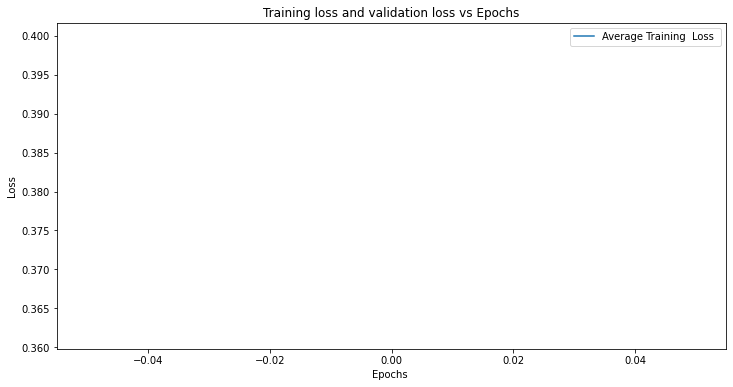

In [ ]:
plot_loss(train_loss)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
def accuracy(model,dll):
  # y_train_temp = y_test.to("cpu").detach().numpy()
  model.eval()
  y_train_pred=[]
  y_test=[]
  for batch in tqdm(dll,leave=True,position=1):
    inputs = batch['images']
    rgb = inputs.repeat(1,3, 1, 1).to(device)
    zz= model(rgb).to("cpu").detach().numpy()
    y_train_pred+=list(zz)
    y_test+=list(torch.squeeze(batch['study_type']).numpy())
  

  for i in range(len(y_train_pred)):
    if y_train_pred[i] >= 0.5:
      y_train_pred[i] = 1
    else:
      y_train_pred[i] = 0
  train_acc = accuracy_score(y_test, y_train_pred)
  clr = classification_report(y_test, y_train_pred)
  f1_sc = f1_score(y_test, y_train_pred, average='weighted')
  print("The accuracy score is :", train_acc)
  print("The weighted F1_score is :", f1_sc)
  print("The classification report is :\n", clr)
  return train_acc, f1_sc

In [ ]:
def unpack_dataloader_with_predictions(model, dl) :

  model.eval()
  y_true = []
  y_pred = []
  regions = []

  for batch in tqdm(dl, leave = True, position = 1) :
    inputs = batch['images']
    rgb = inputs.repeat(1,3, 1, 1).to(device)
    zz = model(rgb).to("cpu").detach().numpy()
    y_pred += list(zz)
    y_true += list(torch.squeeze(batch['study_type']).numpy())
    regions += list(torch.squeeze(batch['region']).numpy())

  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  regions = np.array(regions)

  mask = y_pred >= 0.5
  y_pred[mask] = 1
  y_pred[~mask] = 0

  return y_true, y_pred, regions

In [ ]:
 def region_wise_metrics(y_true, y_pred, regions_code) :

  def metrics(y_true, y_pred) :

    acc = accuracy_score(y_true, y_pred)
    clr = classification_report(y_true, y_pred)
    f1_sc = f1_score(y_true, y_pred, average = 'weighted')
    print("The accuracy score is :", acc)
    print("The weighted F1_score is :", f1_sc)
    print("The classification report is :\n", clr)

    return acc, f1_sc

  regions = []
  metric_scores = []

  print('For all the regions')
  acc, f1_sc = metrics(y_true, y_pred)

  regions.append('all')
  metric_scores.append((acc, f1_sc))

  num_regions = 7
  for region in range(num_regions) :
    mask = regions_code == region
    specific_preds = y_pred[mask]
    specific_trues = y_true[mask]

    region_label = region_code_to_label[region]

    print(f"For region '{region_label}' :")
    acc, f1_sc = metrics(specific_preds, specific_trues)

    regions.append(region_code_to_label[region])
    metric_scores.append((acc, f1_sc))
  
  regions = np.array(regions)
  metric_scores = np.array(metric_scores)

  return regions, metric_scores

In [ ]:
def plot_multi_bars(values, labels, title, xlabel, ylabel, xticks, save = False) : 

  width = 0.2
  m = values.shape[0]
  n = values.shape[1]
  indexes = np.arange(m)
  fig, ax = plt.subplots()
  for i in range(n) :
    ax.bar(indexes + i * width, values[:,i], width, label = labels[i])
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.xticks(indexes + width * n / 2 - 0.1, xticks)
  ax.legend(loc = 'best')
  # if save is not None:
  #   plt.savefig(f"{root_folder}/{title}.png")
  plt.show()

In [ ]:
y_train_true, y_train_pred, train_regions = unpack_dataloader_with_predictions(net, dll)

In [ ]:
train_region_labels, train_metric_scores = region_wise_metrics(y_train_true, y_train_pred, train_regions)

In [ ]:
train_metric_scores

In [ ]:
plot_multi_bars(train_metric_scores, np.array(['Accuracy', 'F1 Score']), 'Analysing Model Performance over different regions', 'Region', 'Metric Score', train_region_labels)

In [ ]:

torch.save(net.state_dict(), "5-epoch-densenet-finalm10")
with open('5-epoch-densenet-final_pkl10', 'wb') as files:
    pickle.dump(net, files)

In [ ]:
ds_val = hub.load("hub://activeloop/mura-val",read_only=True)

hub://activeloop/mura-val loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/mura-val


In [ ]:
dll_test=ds_val.pytorch(batch_size=64,transform = {'images': preprocess, 'study_type': None})

In [ ]:
accuracy(net,dll_test)


100%|██████████| 47/47 [00:44<00:00,  1.05it/s]

The accuracy score is : 0.7572196104768301
The weighted F1_score is : 0.7499376905540339
The classification report is :
               precision    recall  f1-score   support

           0       0.89      0.59      0.71      1480
           1       0.69      0.93      0.79      1498

    accuracy                           0.76      2978
   macro avg       0.79      0.76      0.75      2978
weighted avg       0.79      0.76      0.75      2978



(0.7572196104768301, 0.7499376905540339)